In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from math import ceil, sqrt
import copy

In [3]:
class MultiDimensionalBS:
    def __init__(self, initial_prices, interest_rate, dividends, volatilities, correlation_matrix):
        self.initial_prices = initial_prices
        self.interest_rate = interest_rate
        self.dividends = dividends
        self.volatilities = volatilities
        self.correlation_matrix = correlation_matrix
        self.dimension = len(initial_prices)
        self.var_cov = np.linalg.cholesky(np.matmul(np.diag(self.volatilities), np.matmul(self.correlation_matrix, np.diag(self.volatilities))))
    
    def Simulate(self, expiry, nb_time_discr, number_paths):
        diffusion_list = np.linspace(0, expiry, nb_time_discr + 1)
        last_index = len(diffusion_list) - 1
        delta_time = expiry / last_index
        dW = np.sqrt(delta_time) * np.random.randn(number_paths, last_index, self.dimension)
        dW = np.append(np.zeros((number_paths, 1, self.dimension)), dW, axis=1)
        cst = self.interest_rate - self.dividends - 0.5 * (self.volatilities ** 2)
        W = np.cumsum(np.matmul(dW, self.var_cov), axis = 1)
        S = self.initial_prices * np.exp(cst * diffusion_list[np.newaxis, :, np.newaxis] + W)
                    
        return S
    
    def Simulate_Next_State(self, current_price, current_time, diffusion_times, nb_paths):
        delta_time = diffusion_times[0] - current_time
        dW = np.sqrt(delta_time) * np.random.randn(nb_paths, len(diffusion_times), self.dimension)
        cst = self.interest_rate - self.dividends - 0.5 * (self.volatilities ** 2)
        W = np.cumsum(np.matmul(dW, self.var_cov), axis = 1)
        S = current_price[:, np.newaxis, np.newaxis, :] * np.exp(cst * (diffusion_times[np.newaxis, :, np.newaxis] - current_time) + W)
                    
        return S

In [4]:
class Payoff:
    def __init__(self, strike, option_type):
        self.strike = strike
        self.option_type = option_type
        
    def value(self, asset_prices, interest_rate, dates, k=0):
        if (self.option_type == 0):
            return np.exp(-interest_rate * dates[np.newaxis, k:]) * np.maximum(asset_prices.max(axis = 2) - self.strike, 0)
        
        elif (self.option_type == 1):
            return np.exp(-interest_rate * dates[np.newaxis, k:]) * np.maximum(self.strike - asset_prices.min(axis = 2), 0)
        
        elif (self.option_type == 2):
            d = len(asset_prices[0][0])
            np.exp(-interest_rate * dates[np.newaxis, k:]) * np.maximum(asset_prices.prod(axis = 2)**(1/d) - self.strike, 0)

In [5]:
##### BS parameters

nb_assets = 5
interest_rate = 0.05
expiry = 3
nb_ex_dates = 9
strike = 100
my_payoff = Payoff(strike, 0)

initial_prices = np.full(nb_assets, 100)
dividends = np.full(nb_assets, 0.1)
volatilities = np.full(nb_assets, 0.2)
diffusion_times = np.linspace(0, expiry, nb_ex_dates + 1)
correlation_matrix = np.eye(nb_assets)

# # Train Neural Net

In [6]:
# NN parameters
nb_epochs = 3000
batch_size = 8192
inputs_size = batch_size * 1
q1 = q2 = 40 + nb_assets
learning_rate = 0.001

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
nn_base = nn.Sequential(nn.Linear(nb_assets + 1, q1), nn.BatchNorm1d(q1), nn.ReLU(), nn.Linear(q1, q2), 
                                        nn.BatchNorm1d(q2), nn.ReLU(), torch.nn.Linear(q2, 1), torch.nn.Sigmoid())

In [11]:
def model_train(nb_epochs, inputs_size, batch_size, learning_rate, N, re_use_nn_params = False):

    #################################################################################################################
    ####################################################                  MODELS INIT
    
    nb_batches = ceil(inputs_size / batch_size)
    f = [copy.deepcopy(nn_base).to(device) for i in range(N - 1)]
    optimizers = [torch.optim.Adam(f[i].parameters(), lr = learning_rate) for i in range(N - 1)]
    BS = MultiDimensionalBS(initial_prices, interest_rate, dividends, volatilities, correlation_matrix)
    losses = np.array([[0.0] * (N - 1)] * int(nb_epochs / 50))
    comp = 0
    
    #################################################################################################################
    ####################################################                  TRAINING

    for epoch in range(nb_epochs):
        S_train = BS.Simulate(expiry, N, inputs_size)
        x = torch.from_numpy(S_train).float()
        y = torch.unsqueeze(torch.from_numpy(my_payoff.value(S_train, interest_rate, diffusion_times)), dim=2).float()
        payoff_tau = [y[i * batch_size : min((i + 1) * batch_size, inputs_size) , N].to(device) for i in range(nb_batches)]
        this_epoch_loss = [0.0] * (N - 1)

        # bakward induction
        
        for n in range(N - 1, 0, -1):
            inputs = torch.cat((x[:,n], y[:,n]), 1)
            payoffs = [y[i * batch_size : min((i + 1) * batch_size, inputs_size) , n] for i in range(nb_batches)]
            
            if n < N - 2 and re_use_nn_params:
                f[n].parameters = f[n + 1].parameters
            
            for batch in range(nb_batches):
                this_batch_inputs = inputs[batch * batch_size : min((batch + 1) * batch_size, inputs_size), :].to(device)
                optimizers[n - 1].zero_grad()
                F_n = f[n - 1](this_batch_inputs)
                f_n = (F_n >= 0.5).detach().float()
                payoffs_batch = y[batch * batch_size : min((batch + 1) * batch_size, inputs_size) , n].to(device)
                payoff_tau[batch] = payoffs_batch * f_n + payoff_tau[batch] * (1 - f_n)
                z = torch.mean(torch.mul(torch.subtract(payoff_tau[batch], payoffs_batch), F_n))
                this_epoch_loss[n - 1] = z.item()
                z.backward()
                optimizers[n - 1].step()
                
        if(epoch % 50 == 0):
            losses[comp] = this_epoch_loss 
            print('epoch {}, losses : {}'.format(epoch, losses[comp]))
            print('\n')
            comp += 1
                
    return f, losses

In [12]:
my_models, losses = model_train(nb_epochs, inputs_size, batch_size, learning_rate, nb_ex_dates)

epoch 0, losses : [1.2039094  0.81609917 0.53678793 0.33152485 0.16402    0.10767576
 0.08065405 0.00475492]


epoch 50, losses : [2.22419047 1.58911753 1.19058192 0.84727108 0.63702142 0.39221081
 0.28329051 0.10990529]


epoch 100, losses : [1.04205453 0.65537596 0.45956317 0.30332065 0.18965191 0.12063567
 0.11419243 0.05849584]


epoch 150, losses : [ 0.41725534  0.29175764  0.18091866  0.06432973  0.00609679 -0.0257486
  0.01016013 -0.03635094]


epoch 200, losses : [0.22505192 0.17786761 0.15342686 0.07498824 0.04245114 0.02068957
 0.01973377 0.00078806]


epoch 250, losses : [ 0.13614029  0.09055069  0.04677907  0.00610409  0.03471658 -0.01930446
  0.01372305  0.00067412]


epoch 300, losses : [ 0.09457548  0.05538251  0.02004209  0.00983888  0.01709586  0.01689601
 -0.03546107  0.02479185]


epoch 350, losses : [0.07021128 0.04532022 0.03554435 0.02163089 0.00313959 0.02711035
 0.02499268 0.0219103 ]


epoch 400, losses : [ 0.05210139  0.03744102  0.00965733  0.03722339  0.0312

Text(0, 0.5, 'loss')

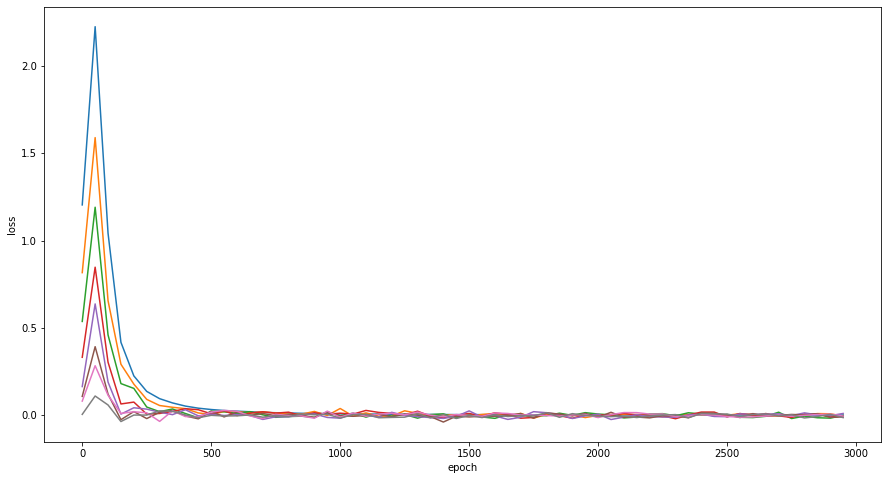

In [13]:
epoch = np.array([i * 50 for i in range(60)])
plt.figure(figsize=(15,8))
for i in range(len(losses[0])):
    plt.plot(epoch, losses[:,i])
plt.xlabel("epoch")
plt.ylabel("loss")

# # Lower Bound

In [15]:
K_L = 1096000
BS_lower = MultiDimensionalBS(initial_prices, interest_rate, dividends, volatilities, correlation_matrix)
S_lower = BS_lower.Simulate(expiry, nb_ex_dates, K_L)
x = torch.from_numpy(S_lower).float()
y = torch.unsqueeze(torch.from_numpy(my_payoff.value(S_lower, interest_rate, diffusion_times)), dim=2).float()

In [18]:
# init
tau = y[:,nb_ex_dates].new_full(y[:,nb_ex_dates].shape, nb_ex_dates).to(device)
payoff_tau = y[:,nb_ex_dates].to(device)

# backward induction
for n in range(nb_ex_dates - 1, 0, -1):
    inputs = torch.cat((x[:,n], y[:,n]), 1)
    f_n = (my_models[n - 1](inputs.to(device)) >= 0.5).detach().float()
    tau = n * f_n + tau * (1 - f_n)
    payoffs = y[:, n].to(device)
    payoff_tau = payoffs * f_n + payoff_tau * (1 - f_n)
    print(n, 'reward :', payoff_tau.mean())
    
# initial date
payoffs = y[:,0].to(device)
f_n = (payoffs >= (payoff_tau).mean()).detach().float()
tau *= (1 - f_n)
payoff_tau = payoffs * f_n + payoff_tau * (1 - f_n)

lower = payoff_tau
lower_bound = lower.mean().item()
print(0, 'reward :', payoff_tau.mean())

8 reward : tensor(24.0065, device='cuda:0')
7 reward : tensor(24.7302, device='cuda:0')
6 reward : tensor(25.2801, device='cuda:0')
5 reward : tensor(25.6800, device='cuda:0')
4 reward : tensor(25.9449, device='cuda:0')
3 reward : tensor(26.0811, device='cuda:0')
2 reward : tensor(26.1112, device='cuda:0')
1 reward : tensor(26.1112, device='cuda:0')
0 reward : tensor(26.1112, device='cuda:0')


In [19]:
print('tau :', round(tau.mean().item(), 3), 'lower bound :', round(lower_bound, 3))

tau : 7.096 lower bound : 26.111


# # Upper Bound

In [20]:
J = 16384
K_U = 1024
BS_upper = MultiDimensionalBS(initial_prices, interest_rate, dividends, volatilities, correlation_matrix)

In [22]:
S_upper = BS_upper.Simulate(expiry, nb_ex_dates, K_U)
x = torch.from_numpy(S_upper).float()
y = torch.unsqueeze(torch.from_numpy(my_payoff.value(S_upper, interest_rate, diffusion_times)), dim=2).float()

In [23]:
S_cond = BS_upper.Simulate_Next_State(S_upper[:, nb_ex_dates - 1, :], diffusion_times[nb_ex_dates - 1], diffusion_times[nb_ex_dates:], J)
y_cond = [my_payoff.value(S_cond[k], interest_rate, diffusion_times[nb_ex_dates:]) for k in range(K_U)]
C_n_1 = torch.from_numpy(np.mean(np.squeeze([y_cond[k] for k in range(K_U)], axis = 2), axis = 1)).to(device)
mg_increments = torch.from_numpy(np.array([[0.0] * K_U] * (nb_ex_dates + 1)))
mg_increments[nb_ex_dates] = y[:, nb_ex_dates, 0].to(device) - C_n_1
f_n = [[torch.from_numpy(np.array([[1.0] * 1] * J)).to(device)] * 1] * K_U

for n in range(nb_ex_dates - 1, 0, -1):
    S_cond = BS_upper.Simulate_Next_State(S_upper[:, n - 1, :], diffusion_times[n - 1], diffusion_times[n:], J)
    y_cond = [torch.unsqueeze(torch.from_numpy(my_payoff.value(S_cond[k], interest_rate, diffusion_times[n:])), dim = 2).float() for k in range(K_U)]
    S_cond = torch.from_numpy(S_cond).float()
    
    inputs = [[torch.cat((S_cond[k][:, m], y_cond[k][:, m]), 1) for m in range(0, nb_ex_dates - n)] for k in range(K_U)]
    payoff_tau = [y_cond[k][:, nb_ex_dates - n].to(device) for k in range(K_U)]
        
    if (not (n == nb_ex_dates - 1)):
        f_n = [[(my_models[n + m - 1](inputs[k][m].to(device)) >= 0.5).detach().float() for m in range(0, N - n)] for k in range(K_U)]
        
        for m in range(N - n - 1, -1, -1):
            payoff_tau = [y_cond[k][:, m, :].to(device) * f_n[k][m] + (1 - f_n[k][m]) * payoff_tau[k] for k in range(K_U)]
    
    C_n = C_n_1
    C_n_1 = [torch.mean(torch.squeeze(payoff_tau[k], dim = 1)).item() for k in range(K_U)]
    C_n_1 = torch.from_numpy(np.array(C_n_1)).to(device)
        
    inputs = torch.cat((x[:,n], y[:,n]), 1)
    f_n = (my_models[n - 1](inputs.to(device)) >= 0.5).detach().float()
    mg_increments[n] = (y[:, n, 0].to(device) - C_n) * torch.squeeze(f_n, dim = 1) + C_n - C_n_1
    
mg_doob = torch.cumsum(torch.transpose(mg_increments, 0, 1), dim = 1)

upper = (y[:,:,0].to(device) - mg_doob.to(device)).max(dim = 1).values
upper_bound = upper.mean().item()

NameError: name 'N' is not defined

In [ ]:
print('upper bound :', round(upper_bound, 3))

In [ ]:
IC_inf = round(lower_bound - 1.96 * torch.std(lower).item() / sqrt(K_L), 3)
IC_sup = round(upper_bound + 1.96 * torch.std(upper).item() / sqrt(K_U), 3)

print('- lower bound :', round(lower_bound, 3))
print('- upper bound :', round(upper_bound, 3))
print('- point estimator :', round((lower_bound + upper_bound) / 2.0, 3))
print('')
print('IC 90% :', (IC_inf, IC_sup))

In [ ]:
# to do : qq tests et graphes

##### 